# Import packages 


In [63]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
import pandas as pd
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load the data 

In [64]:
# load dataset
df=pd.read_csv('/Users/yingyuxuan/Desktop/covid19-global-forecasting-week-5/data/new_df.csv').drop(columns='Unnamed: 0')
# obtian fatality cases data 
confirm=df[df.Target=='ConfirmedCases'].drop(columns='Target')
confirm[confirm.Date=='2020-02-04'].head(-50)

,Country_Region,Date,month,day,Population,Weight,TargetValue
24,Afghanistan,2020-02-04,2,4,27657145,0.058359,0.0
272,Albania,2020-02-04,2,4,2886026,0.067225,0.0
520,Algeria,2020-02-04,2,4,40400000,0.057096,0.0
768,Andorra,2020-02-04,2,4,78014,0.088773,0.0
1016,Angola,2020-02-04,2,4,25868000,0.058587,0.0
...,...,...,...,...,...,...,...
845208,US,2020-02-04,2,4,136034,0.084598,0.0
845456,US,2020-02-04,2,4,404198,0.077461,0.0
845704,US,2020-02-04,2,4,50990,0.092256,0.0
845952,US,2020-02-04,2,4,24443,0.098969,0.0


# Data Standardization


In [29]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(confirm.drop(columns=['TargetValue','Country_Region','Date']))
# create datefrane fir scaled data
scaled_df=pd.DataFrame(data=scaled,columns=confirm.drop(columns=['TargetValue','Country_Region','Date']).columns)

In [53]:
confirmed_Cases=confirm.copy()
confirmed_Cases[scaled_df.columns]=np.array(scaled_df)
confirmed_Cases['country']=list(confirmed_Cases.Country_Region)

In [54]:
confirmed_Cases=confirmed_Cases.set_index(['Country_Region','Date'])
confirmed_Cases.head()

month       day  Population  Weight  TargetValue  \
Country_Region Date                                                           
Afghanistan    2020-01-23    0.0  0.733333    0.019815  0.0616          0.0   
               2020-01-24    0.0  0.766667    0.019815  0.0616          0.0   
               2020-01-25    0.0  0.800000    0.019815  0.0616          0.0   
               2020-01-26    0.0  0.833333    0.019815  0.0616          0.0   
               2020-01-27    0.0  0.866667    0.019815  0.0616          0.0   

                               country  
Country_Region Date                     
Afghanistan    2020-01-23  Afghanistan  
               2020-01-24  Afghanistan  
               2020-01-25  Afghanistan  
               2020-01-26  Afghanistan  
               2020-01-27  Afghanistan

#  Train Test Split

In [32]:
def train_test_split(data):
    size=int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train =data.drop(columns=['TargetValue']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['TargetValue']).iloc[size:]
    y_train=data['TargetValue'].iloc[0:size] 
    y_test=data['TargetValue'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [55]:
country=list(set(confirmed_Cases.country))
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=confirmed_Cases[confirmed_Cases['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split(data)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [56]:
# concat each train data from each station 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each station 
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [57]:
# double check the train data and test data and our target 
X_train.head(2)

month       day    Population    Weight   country
Country_Region Date                                                         
Holy See       2020-01-23    0.0  0.733333  2.615038e-07  0.657928  Holy See
               2020-01-24    0.0  0.766667  2.615038e-07  0.657928  Holy See

# Data Preprocessing

In [58]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test


In [59]:
encoder = LabelEncoder()
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])
test_data.shape

(85922, 6)

In [60]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

# Model 

In [67]:
# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=30, batch_size=50,  verbose=1, shuffle=False)


Epoch 1/30
343489/343489 [==============================] - 17s 49us/step - loss: 6.1027
Epoch 2/30
343489/343489 [==============================] - 15s 44us/step - loss: 5.7518
Epoch 3/30
343489/343489 [==============================] - 16s 47us/step - loss: 5.7534
Epoch 4/30
343489/343489 [==============================] - 20s 58us/step - loss: 5.7155
Epoch 5/30
343489/343489 [==============================] - 16s 48us/step - loss: 5.6894
Epoch 6/30
343489/343489 [==============================] - 16s 47us/step - loss: 5.6751
Epoch 7/30
343489/343489 [==============================] - 17s 49us/step - loss: 5.6883
Epoch 8/30
343489/343489 [==============================] - 16s 47us/step - loss: 5.6647
Epoch 9/30
343489/343489 [==============================] - 16s 45us/step - loss: 5.6596
Epoch 10/30
343489/343489 [==============================] - 15s 45us/step - loss: 5.6627
Epoch 11/30
343489/343489 [==============================] - 18s 53us/step - loss: 5.6553
Epoch 12/30
343489/

In [71]:
history.history.keys()

dict_keys(['loss'])

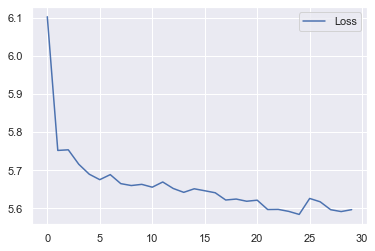

In [72]:
# plot history
plt.plot(history.history['loss'], label='Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Make prediction

In [73]:
# make a prediction
y_test_pre=model.predict(x_test)
# check length
y_test_pre.shape,y_test.shape

((85921, 1), (85921,))

In [74]:
# combine scaled data with predicted target
df_inverse1=X_test[scaled_df.columns]
# inverse test data
test_inv_pre=pd.DataFrame(scaler.inverse_transform(df_inverse1))
# get the month and day columns
month_day=test_inv_pre[[0,1]]
# obtian the date
import datetime
date=[]
for i in range(len(month_day)):
    d = datetime.datetime(2020, int(month_day[0][i]),int(month_day[1][i])).date()
    date.append(d)

# Model Evaluation


In [75]:
pa=pd.DataFrame()
pa['Date']=date[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa.head()

,Date,Prediction,Actual Values
0,2020-05-02,-0.012346,0.0
1,2020-05-03,-0.012035,0.0
2,2020-05-04,-0.011725,0.0
3,2020-05-05,-0.011415,0.0
4,2020-05-06,0.227799,1.0


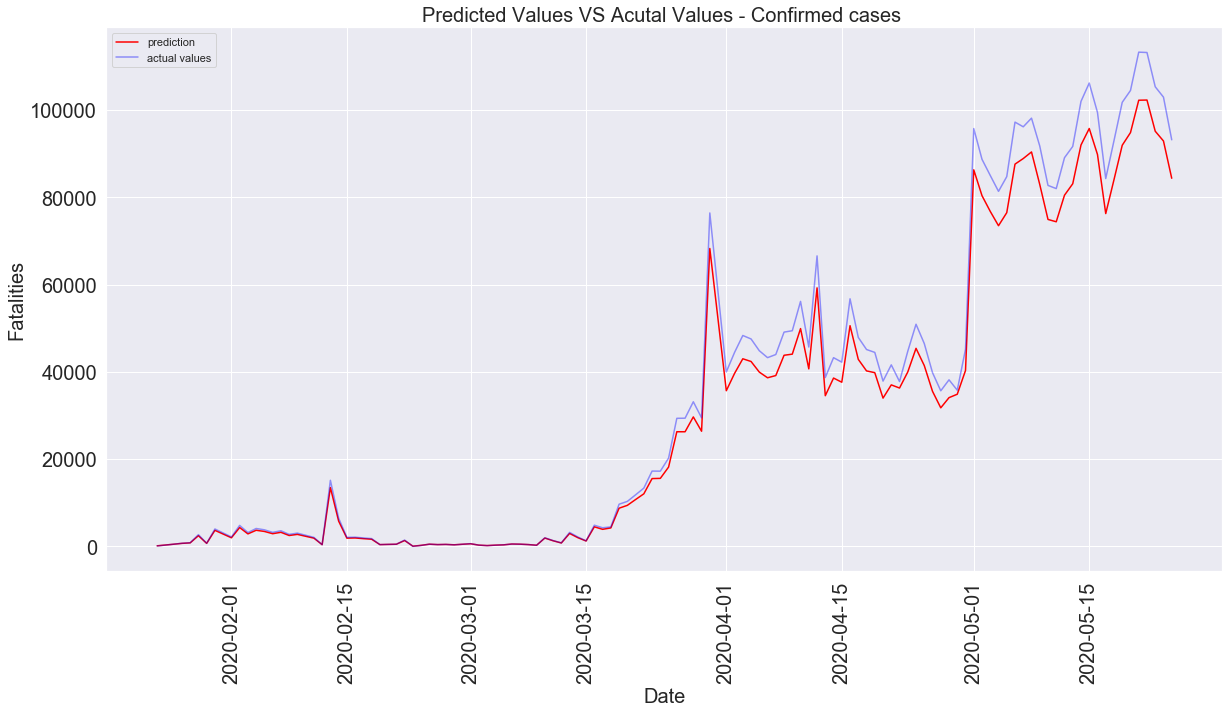

In [76]:
plt.figure(figsize=(20,10))
pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('Fatalities',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Acutal Values - Confirmed cases ',fontsize=20)
plt.legend()


In [77]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    print(rmse)

In [78]:
RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:])

88.67236888350938
